# The Task

Given the user query, we would like to predict which tags the given query best belongs to.

# Data Loading and EDA

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
# import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud
EN = spacy.load('en_core_web_sm')

In [3]:
data = pd.read_csv('/content/gdrive/My Drive/Stackoverflow_VS_extension/Preprocessed_data.csv')
print(data.shape)
data.head()

(147059, 10)


,original_title,post_corpus,question_content,question_url,tags,overall_scores,answers_content,sentiment_polarity,sentiment_subjectivity,processed_title
0,Using 'in' to match an attribute of Python obj...,using match attribute python objects array nt ...,using match attribute python objects array nt ...,https://stackoverflow.com/questions/683,python|arrays|iteration,0.011301,Using a list comprehension would build a tempo...,0.163567,0.568209,using match attribute python objects array
1,Python version of PHP's stripslashes,python version php stripslashes wrote piece co...,python version php stripslashes wrote piece co...,https://stackoverflow.com/questions/13454,python|string|escaping,0.001115,Python has a built-in escape() function analog...,0.195000,0.519274,python version php stripslashes
2,Unicode vs UTF-8 confusion in Python / Django?,unicode vs utf8 confusion python django stumbl...,unicode vs utf8 confusion python django stumbl...,https://stackoverflow.com/questions/22149,python|django|unicode,0.006997,From Wikipedia on UTF-8:,0.082857,0.403250,unicode vs utf8 confusion python django
3,Using Django time/date widgets in custom form,using django time date widgets custom form use...,using django time date widgets custom form use...,https://stackoverflow.com/questions/38601,python|django,0.041431,"Starting in Django 1.2 RC1, if you're using th...",0.302423,0.599938,using django time date widgets custom form
4,Can parallel traversals be done in MATLAB just...,parallel traversals done matlab python using f...,parallel traversals done matlab python using f...,https://stackoverflow.com/questions/49307,python|arrays|matlab|for-loop,0.002837,should be for example:,0.358333,0.752381,parallel traversals done matlab python


In [4]:
# Make a dict having tag frequencies
data.tags = data.tags.apply(lambda x: x.split('|'))
tag_freq_dict = {}
for tags in data.tags:
    for tag in tags:
        if tag not in tag_freq_dict:
            tag_freq_dict[tag] = 0
        else:
            tag_freq_dict[tag] += 1

## Visualize tags

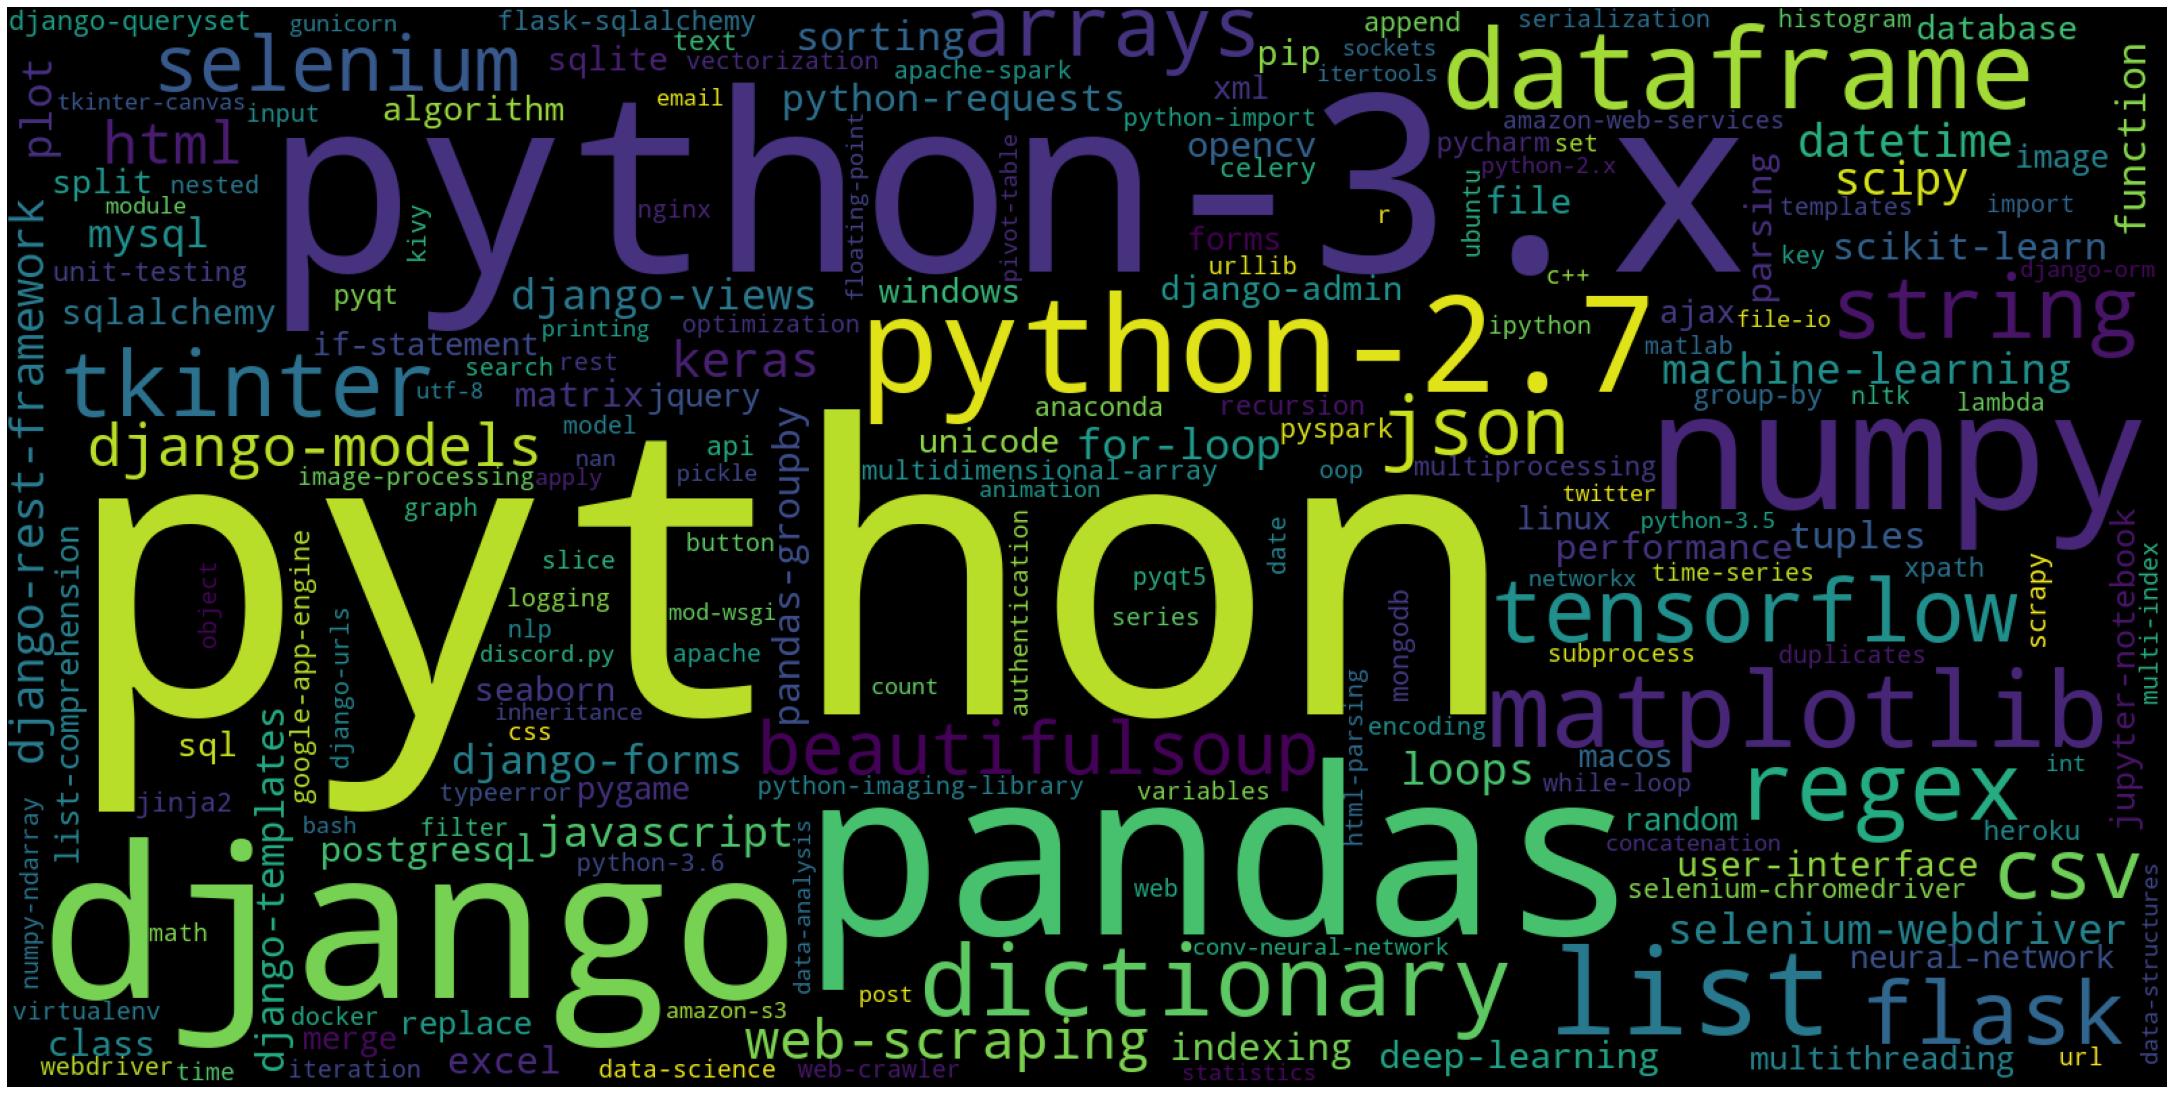

In [5]:
# Visualize all tags based on their frequencies using a WordCloud
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tag_freq_dict)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Although we did filter out a lot of tags in Data processing step, there still exists a lot of "stray" tags which may appear only once or twice as compared to thousands of occurences for other tags. This increases the dimensions of the ground truth data, which is not desirable for our model. Thus we extract the top 500 tags based on their occurences. Given that we have ~140k data points, 500 tags seems to be a good number to experiment with

In [6]:
# Get most common tags
tags_to_use = 500
tag_freq_dict_sorted = dict(sorted(tag_freq_dict.items(), key=lambda x: x[1], reverse=True))
final_tags = list(tag_freq_dict_sorted.keys())[:tags_to_use]
len(final_tags)

500

Finally, we altered the tag data to only include tags from one of these 500 tags, for better model accuracy  

In [7]:
# Change tag data to only for final_tags
final_tag_data = []
for tags in data.tags:
    temp = []
    for tag in tags:
        if tag in final_tags:
            temp.append(tag)
    final_tag_data.append(temp)

## One - hot encode the ground truth data

Since we are dealing with multi label data, i.e. there are more than one answers for each input, I decided to use the MultiLabelBinarizer from sklearn

**For Example**
If we have total tags as [python, django,flask,nginx,gunicorn], our ground truth of [python, flask] would get converted to [1,0,1,0,0]

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(final_tag_data)
tags_encoded.shape

(147059, 500)

# Train Word Embeddings

In order for our model to understand the raw text data, we need to vectorize it. Bag of Words and TF-IDF are very common approaches for vectorizing. However, since I would be using an artificial neural network as my model, the sparse nature of BOW and TFIDF would pose a problem. Thus I decided to go for Word Embeddings, which are dense vector representations and thus perfect for our neural network.


The way talk on StackOverflow is very technical and they use a very specific vocabulary of words, it is not a good idea to use pre-trained WordEmbedding (although google has a lot of good ones) because they are trained on plain English text such a Shakespeare and would not be able to understand the relations between the words in our vocabulary. Thus I decided to train a WordEmbeddings model of my own from scratch.

In [9]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Collect corpus for training word embeddings
documents = [_text.split() for _text in np.array(data.post_corpus)]  # I used the entire corpus for training, because it contains the entire conversation of related to a user's posts

In [10]:
data.post_corpus[0]

'using match attribute python objects array nt remember whether dreaming seem recall function allowed something like using list comprehension would build temporary list could eat memory sequence searched large even sequence large building list means iterating whole sequence could start searchfoo 12 foo objid obj bar'

In [11]:
# Train Word Embeddings and save

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('/content/gdrive/My Drive/Stackoverflow_VS_extension/SO_word2vec_embeddings.bin')


Vocab size 23466


In [12]:
# Load pre-trained embeddings
w2v_model = gensim.models.word2vec.Word2Vec.load('/content/gdrive/My Drive/Stackoverflow_VS_extension/SO_word2vec_embeddings.bin')

### Sanity Checks on the trained word embeddings

In [13]:
# Testing Word Embeddings
print('Terms most similar to "django"')
print(w2v_model.wv.most_similar("django"))
print('-'*100)

print('Terms most similar to "api"')
print(w2v_model.wv.most_similar("api"))
print('-'*100)

print('Terms most similar to "gunicorn"')
print(w2v_model.wv.most_similar("gunicorn"))
print('-'*100)

print('Terms most similar to "server"')
print(w2v_model.wv.most_similar("server"))

Terms most similar to "django"
[('flask', 0.585587739944458), ('wagtail', 0.5679296255111694), ('mezzanine', 0.5423597097396851), ('drf', 0.4997471272945404), ('project', 0.4928167462348938), ('admin', 0.48742732405662537), ('ecommerce', 0.4754946231842041), ('framework', 0.47085893154144287), ('template', 0.4693797528743744), ('database', 0.4659475088119507)]
----------------------------------------------------------------------------------------------------
Terms most similar to "api"
[('apis', 0.5936216115951538), ('webservice', 0.5070031881332397), ('framework', 0.500191330909729), ('service', 0.48060691356658936), ('endpoint', 0.4749726951122284), ('piston', 0.4694000482559204), ('postman', 0.452612042427063), ('oauth2', 0.4346615970134735), ('endpoints', 0.4309701919555664), ('application', 0.4251088500022888)]
----------------------------------------------------------------------------------------------------
Terms most similar to "gunicorn"
[('uwsgi', 0.5867525339126587), ('ngi

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Model Training

## Splitting into training and test set
For training the model, I used only the processed_title as the input because we want to provide the user the best results with as little as an information that they need to provide

In [14]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data.processed_title), tags_encoded, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 117647
TEST size: 29412


## Tokenizing
The input data is tokenized using keras's Tokenizer. 

**Note: It was trained on the entire corpus instead of only the titles**. The reason for that is because I wanted to incorporate as many different words necessary into the vocabulary, because the titles provide very less information. 

In [16]:
# Tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.post_corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# saving
import pickle
with open('/content/gdrive/My Drive/Stackoverflow_VS_extension/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Found 469467 unique tokens.


In [17]:
# loading tokenizer
import pickle
with open('/content/gdrive/My Drive/Stackoverflow_VS_extension/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 469467 unique tokens.


In order to have a constant size for the input, I use a pre-defined size called 'MAX_SEQUENCE_LENGTH'. Thus, any input sequence more than this size is truncated, and padded by adding a special PAD token for sequences smaller than it.  

In [18]:
# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (117647, 300)


Finally I constructed an embedding matrix which contains the vectors for all tokens in our vocabulary. This acts as a weights matrix for the Embedding Layer in our neural network

In [19]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(469468, 300)


## Define a custom loss function
Since we are dealing with a multilabel classification problem here, we cannot train the model using a binary crossentrophy loss. Thus I used log loss applied on each class separately and then computed it's mean based on the number of classes

![loss](jupyter_imgs/loss.png)

In [20]:
import keras.backend as K

# Custom loss function to handle multilabel classification task
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    y_true = tf.cast(y_true, dtype='float64')
    y_pred = tf.cast(y_pred, dtype='float64')
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

I used an LSTM layer right after the Embedding layer because of their proficiency in working with sequential and text data. Subsequent Dense layers are added along with Dropout regularization in order to build a robust model 

In [21]:
## Model 1
# # Build Model
# import keras 

# model = Sequential()
# model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# model.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(units = 100,
#                      kernel_initializer = 'glorot_uniform',
#                      activation = 'relu'
#                     )
#               )  
# model.add(Dropout(0.35))
# model.add(Dense(units = 1150,
#                      kernel_initializer = 'glorot_uniform',
#                      activation = 'relu'
#                     )
#               )
# model.add(Dropout(0.25))
# model.add(Dense(units = 75,
#                      kernel_initializer = 'glorot_uniform',
#                      activation = 'relu'
#                     )
#               )
# model.add(Dense(500, activation='sigmoid'))

# model.summary()

# model.compile(loss=multitask_loss,
#               optimizer="adam")
              
# # Train Model
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
#               EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

# BATCH_SIZE = 1024

## Model 2
from keras.layers import Dense, Embedding, LSTM, Dropout,Conv1D,GlobalMaxPool1D,GRU
from keras.layers.normalization import BatchNormalization
from datetime import datetime
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,TensorBoard,ModelCheckpoint
from time import time

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(GRU(300, activation='relu',kernel_initializer='he_normal'))
model.add(Dense(400,activation='relu',kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(150,activation='relu'))
model.add(Dense(500, activation='sigmoid'))
model.summary()

model.compile(loss=multitask_loss,
              optimizer="adam")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          140840400 
_________________________________________________________________
gru (GRU)                    (None, 300)               541800    
_________________________________________________________________
dense (Dense)                (None, 400)               120400    
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               60150     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               7

In [22]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 1024

history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=15,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

# Save model


Epoch 1/15
104/104 [==============================] - 126s 1s/step - loss: 52.6721 - val_loss: 9.0461
Epoch 2/15
104/104 [==============================] - 125s 1s/step - loss: 8.2372 - val_loss: 7.4680
Epoch 3/15
104/104 [==============================] - 126s 1s/step - loss: 7.4673 - val_loss: 7.0350
Epoch 4/15
104/104 [==============================] - 127s 1s/step - loss: 7.1140 - val_loss: 6.8024
Epoch 5/15
104/104 [==============================] - 127s 1s/step - loss: 6.8750 - val_loss: 6.6579
Epoch 6/15
104/104 [==============================] - 127s 1s/step - loss: 6.6391 - val_loss: 6.3938
Epoch 7/15
104/104 [==============================] - 127s 1s/step - loss: 6.4301 - val_loss: 6.1885
Epoch 8/15
104/104 [==============================] - 126s 1s/step - loss: 6.2478 - val_loss: 6.0545
Epoch 9/15
104/104 [==============================] - 126s 1s/step - loss: 6.0968 - val_loss: 5.9250
Epoch 10/15
104/104 [==============================] - 125s 1s/step - loss: 5.9549 - val_l

In [23]:
model.save_weights('/content/gdrive/My Drive/Stackoverflow_VS_extension/Tag_predictor_weights.h5')

In [24]:
# Helper function to save the training history for plotting purposes

import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

In [27]:
from keras.models import load_model
import keras.losses
# TODO: check how this works
keras.losses.multitask_loss = multitask_loss
model = model.load_weights('/content/gdrive/My Drive/Stackoverflow_VS_extension/Tag_predictor_weights.h5')
# history = loadHist('/content/gdrive/My Drive/Stackoverflow_VS_extension/train_history.json')

AttributeError: ignored

## Model Evaluation

In [ ]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("LOSS:",score)

loss = history['loss']
val_loss = history['val_loss']
 
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

18/18 [==============================] - 2s 132ms/step - loss: 6.8033
LOSS: 6.803332328796387


TypeError: ignored

In [ ]:
# A wrapper function in order to predict the tags for any given input

def predict_tags(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    prediction = model.predict([x_test])[0]
    for i,value in enumerate(prediction):
        if value > 0.5:
            prediction[i] = 1
        else:
            prediction[i] = 0
    tags = tag_encoder.inverse_transform(np.array([prediction]))
    return tags

In [ ]:
test_idx = np.random.randint(len(X_test), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test[test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(X_test[test_case])))
    print('Ground Truth: ' + str(tag_encoder.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: matplotlib plot_surface plot
----------------------------------------------------------------------------------------------------
Predicted: [('matplotlib', 'python')]
Ground Truth: [('matplotlib', 'python')]


Test Case: single sqlite row faster 5 updates build python dict 1 update
----------------------------------------------------------------------------------------------------
Predicted: [('python',)]
Ground Truth: [('python', 'python-2.7', 'sqlite')]


Test Case: django runserver page loading pcs
----------------------------------------------------------------------------------------------------
Predicted: [('django', 'python')]
Ground Truth: [('django', 'python-2.7')]


Test Case: inheriting context variables inside custom template tags
----------------------------------------------------------------------------------------------------
Predicted: [('django', 'python')]
Ground Truth: [('django', 'django-templates', 'python')]


Test Case: multiplication list parameter 